# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
import random
from collections import defaultdict
from copy import copy
from itertools import product
from typing import Callable, Union, Optional, Dict, Any, List, Iterable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

In [2]:
SEED = 7
np.random.seed(SEED)
random.seed(SEED)

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [3]:
def get_class_probs(x: np.ndarray) -> np.ndarray:
    _, counts = np.unique(x, return_counts=True)
    return counts / x.shape[0]

def gini(x: np.ndarray) -> float:
    """
    Считает коэффициент Джини для массива меток x.
    """
    probs = get_class_probs(x)
    return 1 - probs.dot(probs)

def entropy(x: np.ndarray) -> float:
    """
    Считает энтропию для массива меток x.
    """
    probs = get_class_probs(x)
    return -probs.dot(np.log2(probs))

def gain(left_y: np.ndarray, right_y: np.ndarray, criterion: Callable) -> float:
    """
    Считает информативность разбиения массива меток.

    Parameters
    ----------
    left_y : np.ndarray
        Левая часть разбиения.
    right_y : np.ndarray
        Правая часть разбиения.
    criterion : Callable
        Критерий разбиения.
    """
    left_size = left_y.shape[0]
    left_information = criterion(left_y)

    right_size = right_y.shape[0]
    right_information = criterion(right_y)

    node_size = left_size + right_size
    node_information = criterion(np.concatenate([left_y, right_y]))

    return node_size * node_information - left_size * left_information - right_size * right_information

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

In [4]:
class DecisionTreeLeaf:
    """

    Attributes
    ----------
    y : dict
        Словарь, отображающий метки в вероятность того, что объект, попавший в данный лист, принадлжит классу, соответствующиему метке
    """
    def __init__(self, classes: np.ndarray):
        classes_names, counts = np.unique(classes, return_counts=True)
        self.y = classes[np.argmax(counts)]
        self.class_probs = defaultdict(float)
        self.class_probs.update({
            cl: p for cl, p in zip(classes_names, counts / classes.shape[0])
        })

class DecisionTreeNode:
    """

    Attributes
    ----------
    split_dim : int
        Измерение, по которому разбиваем выборку.
    split_value : float
        Значение, по которому разбираем выборку.
    left : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] < split_value.
    right : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] >= split_value.
    """
    def __init__(self, split_dim: int, split_value: float,
                 left: Union['DecisionTreeNode', DecisionTreeLeaf],
                 right: Union['DecisionTreeNode', DecisionTreeLeaf]):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right


Node = Union[DecisionTreeNode, DecisionTreeLeaf]

### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [5]:
class DecisionTreeClassifier:
    """
    Attributes
    ----------
    root : Union[DecisionTreeNode, DecisionTreeLeaf]
        Корень дерева.

    (можете добавлять в класс другие аттрибуты).

    """
    def __init__(self, criterion : str = "gini",
                 max_depth : Optional[int] = None,
                 min_samples_leaf: int = 1):
        """
        Parameters
        ----------
        criterion : str
            Задает критерий, который будет использоваться при построении дерева.
            Возможные значения: "gini", "entropy".
        max_depth : Optional[int]
            Ограничение глубины дерева. Если None - глубина не ограничена.
        min_samples_leaf : int
            Минимальное количество элементов в каждом листе дерева.

        """
        self.root = None
        self._max_depth = max_depth
        self._min_samples_leaf = min_samples_leaf

        if criterion == "gini":
            self._criterion = gini
        elif criterion == "entropy":
            self._criterion = entropy
        else:
            raise ValueError(f"Unknown criterion: {criterion}")

    def fit(self, points: np.ndarray, classes: np.ndarray):
        """
        Строит дерево решений по обучающей выборке.

        Parameters
        ----------
        points : np.ndarray
            Обучающая выборка.
        classes : np.ndarray
            Вектор меток классов.
        """
        self.root = self._build_node(points, classes, 0)

    def _build_node(self, points: np.ndarray, classes: np.ndarray, depth: int) -> Node:
        if self._max_depth is not None and depth >= self._max_depth:
            return DecisionTreeLeaf(classes)

        n_points, n_features = points.shape
        split_dim, split_value, split_gain = None, None, 0.0
        for cur_dim in range(n_features):
            for cur_split_val in np.unique(points[:, cur_dim]):
                mask = points[:, cur_dim] < cur_split_val

                left_size = mask.sum()
                right_size = n_points - left_size
                if left_size < self._min_samples_leaf or right_size < self._min_samples_leaf:
                    continue

                cur_gain = gain(classes[mask], classes[~mask], self._criterion)
                if cur_gain > split_gain:
                    split_dim, split_value, split_gain = cur_dim, cur_split_val, cur_gain

        if split_dim is None:
            return DecisionTreeLeaf(classes)
        mask = points[:, split_dim] < split_value
        left_child = self._build_node(points[mask], classes[mask], depth + 1)
        right_child = self._build_node(points[~mask], classes[~mask], depth + 1)
        return DecisionTreeNode(split_dim, split_value, left_child, right_child)

    def predict_proba(self, points: np.ndarray) ->  List[Dict[Any, float]]:
        """
        Предсказывает вероятность классов для элементов из X.

        Parameters
        ----------
        points : np.ndarray
            Элементы для предсказания.

        Return
        ------
        List[Dict[Any, float]]
            Для каждого элемента из X возвращает словарь
            {метка класса -> вероятность класса}.
        """

        return list(self._predict_proba(points, self.root))

    def _predict_proba(self, points: np.ndarray, node: Node) -> Iterable[Dict[Any, float]]:
        result = np.empty(points.shape[0], dtype=np.object)
        if isinstance(node, DecisionTreeLeaf):
            result[:] = copy(node.class_probs)
            return result

        mask = points[:, node.split_dim] < node.split_value
        result[mask] = self._predict_proba(points[mask], node.left)
        result[~mask] = self._predict_proba(points[~mask], node.right)
        return result

    def predict(self, points: np.ndarray) -> List:
        """
        Предсказывает классы для элементов X.

        Parameters
        ----------
        points : np.ndarray
            Элементы для предсказания.

        Return
        ------
        list
            Вектор предсказанных меток для элементов X.
        """
        proba = self.predict_proba(points)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

    def get_path(self, point: np.ndarray) -> List[Tuple[int, float]]:
        return reversed(self._get_path(point, self.root))

    def _get_path(self, point: np.ndarray, node: Node) -> List[Tuple[int, float]]:
        if isinstance(node, DecisionTreeLeaf):
            return []

        if point[node.split_dim] < node.split_value:
            return self._get_path(point, node.left) + [(node.split_dim, node.split_value, "<")]
        else:
            return self._get_path(point, node.right) + [(node.split_dim, node.split_value, ">")]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [6]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [7]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

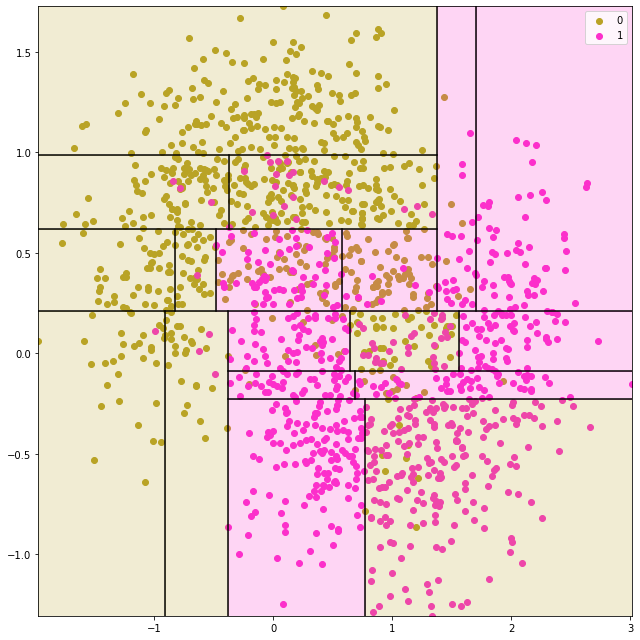

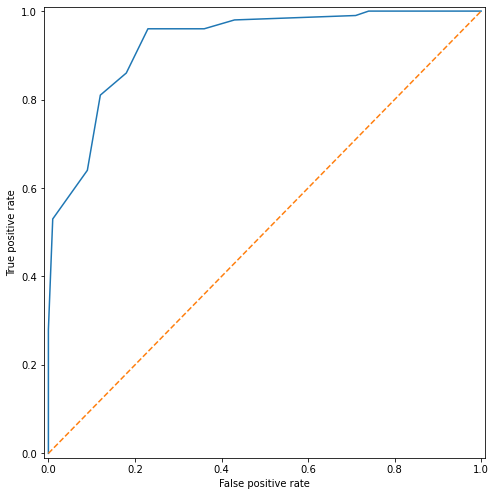

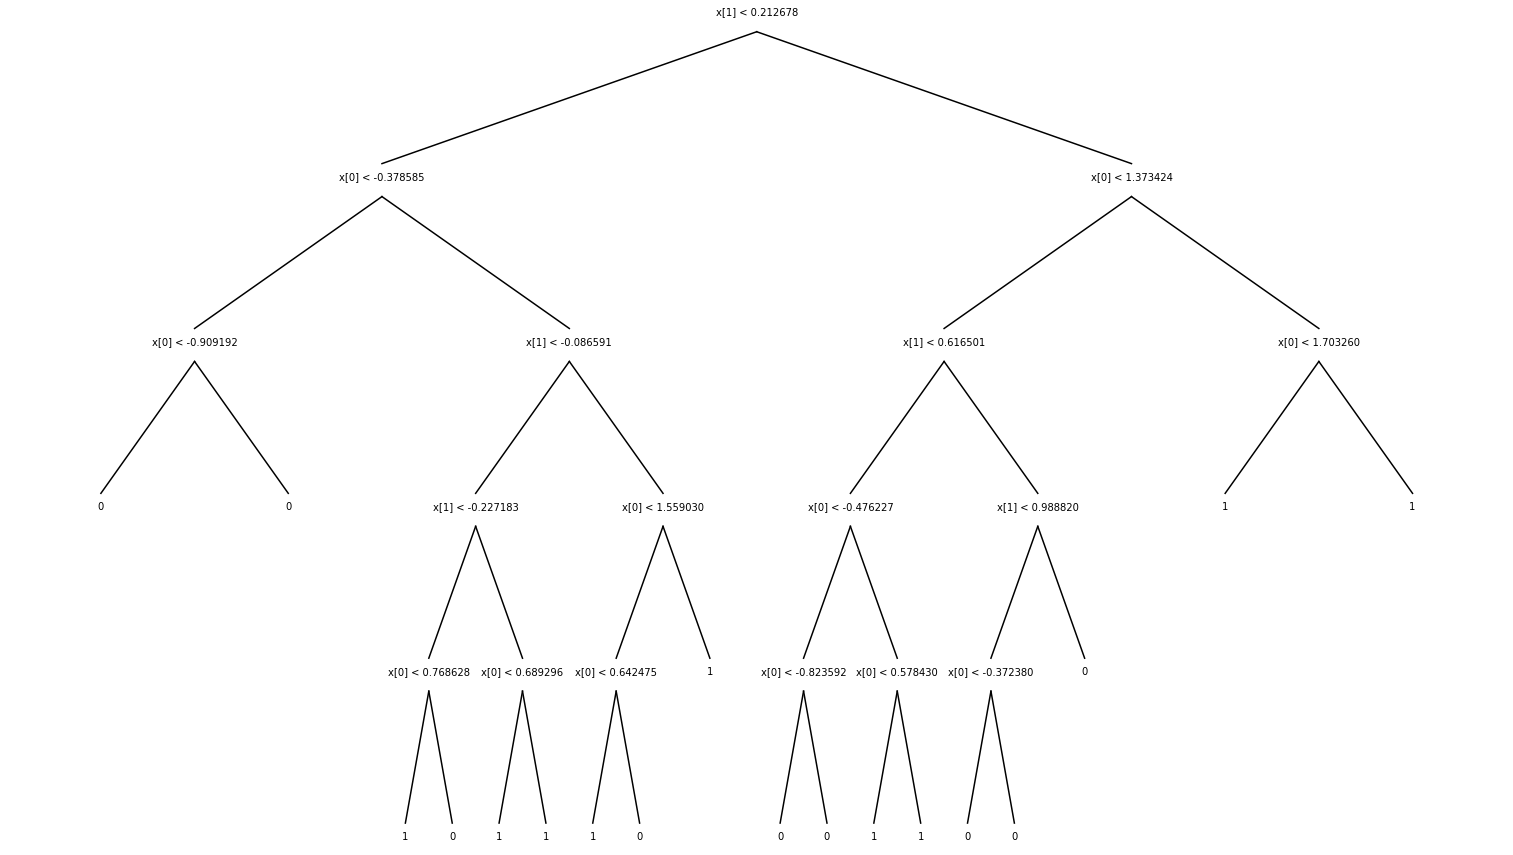

In [8]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

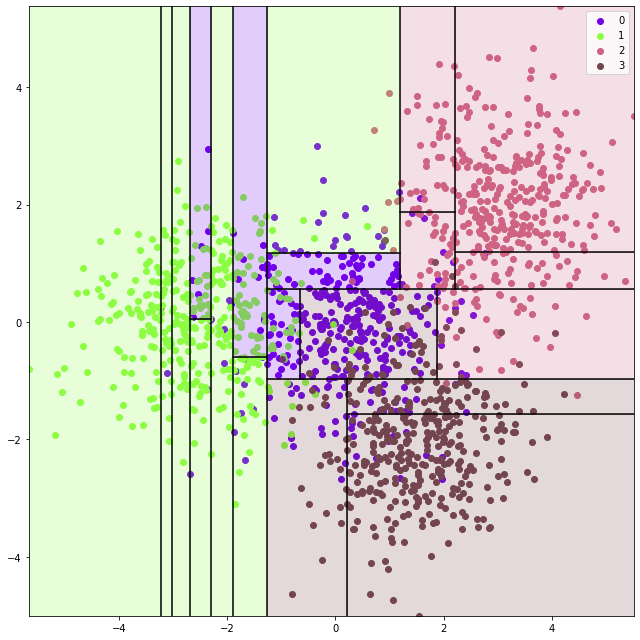

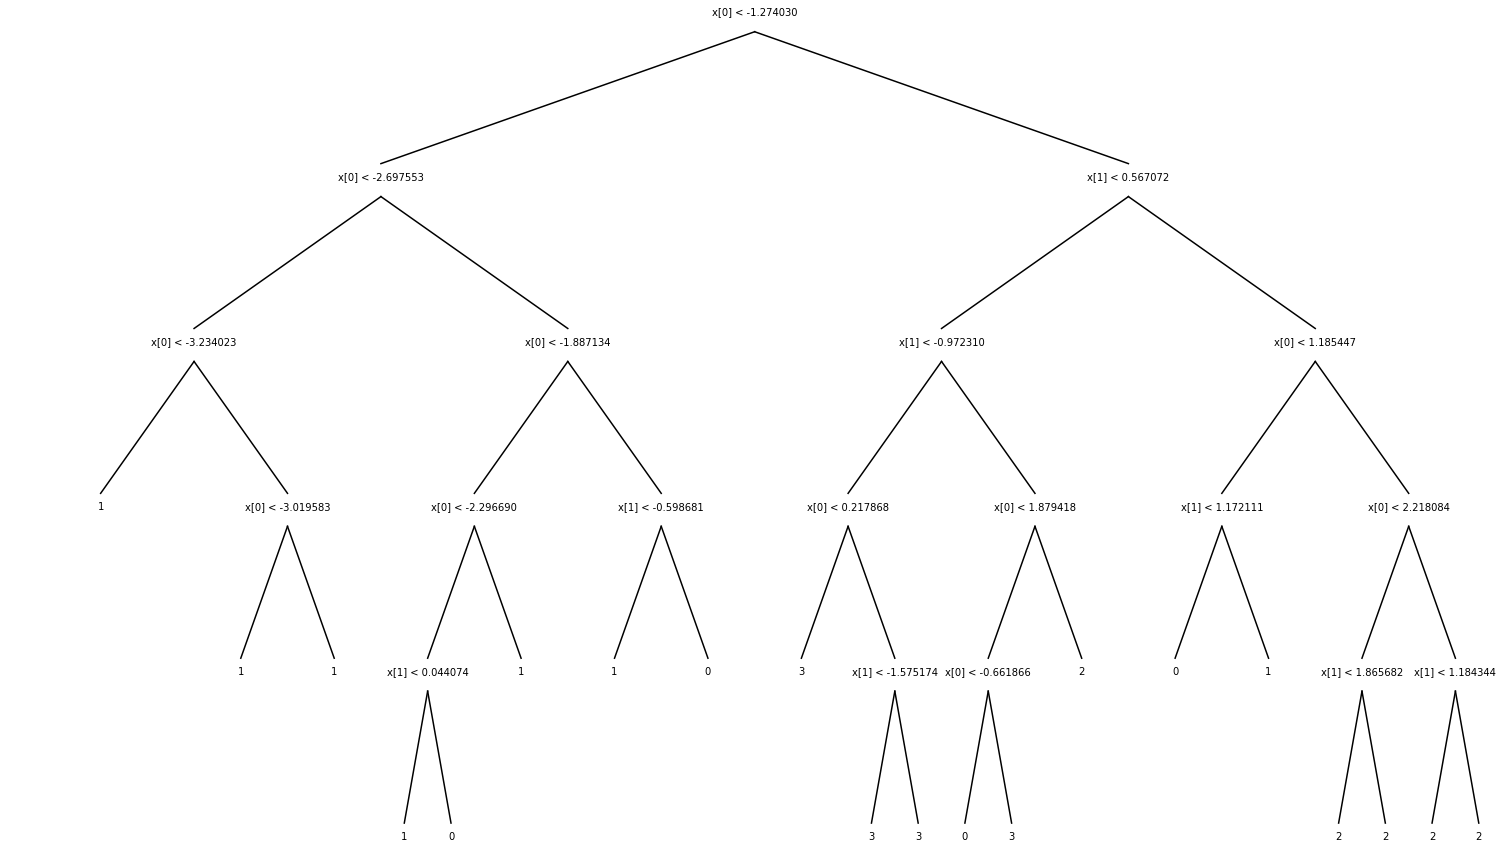

In [9]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (3 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 1 балл - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 3 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [10]:
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=1)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

In [11]:
X, y = read_dataset("train.csv")
X[:5, :], y[:5]

(array([[2.1445428 , 0.42416599, 0.56051626, 0.8       ],
        [0.67437039, 0.00517494, 0.03828595, 0.85789754],
        [1.15766047, 0.07385734, 0.18293482, 0.55286282],
        [3.5053809 , 0.113477  , 0.868771  , 0.30482093],
        [0.65157918, 0.9       , 1.60685554, 0.70209308]]),
 array(['warrior', 'cleric', 'cleric', 'warrior', 'warrior'], dtype='<U7'))

In [12]:
criterion = ["gini", "entropy"]
max_depth = range(1, 20, 2)
min_samples_leaf = range(1, 20, 2)

kfold = KFold(3, shuffle=True, random_state=SEED)

In [13]:
best_score, best_params = None, None

for c, md, msl in tqdm(list(product(criterion, max_depth, min_samples_leaf))):
    results = []
    for train_mask, val_mask in kfold.split(X):
        X_train, X_val = X[train_mask], X[val_mask]
        y_train, y_val = y[train_mask], y[val_mask]

        classifier = DecisionTreeClassifier(c, md, msl)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_val)
        results.append(accuracy_score(y_val, y_pred))

    mean_acc = np.mean(results)
    if best_score is None or mean_acc > best_score:
        best_score = mean_acc
        best_params = (c, md, msl)

best_score, best_params

  0%|          | 0/200 [00:00<?, ?it/s]

(0.9065242881072028, ('entropy', 9, 9))

In [14]:
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=9, min_samples_leaf=9)
dtc.fit(X, y)

### Задание 5 (1 балл)
От игроков начали поступать жалобы на то, что класс их персонажа внезапно сменился. В таких случаях модераторы смотрят на данные персонажа и пытаются восстановить его класс сами. Для того, чтобы им было проще это сделать, нужно научиться для каждого персонажа объяснять, почему дерево решений присвоило персонажу именно такой класс.

Реализуйте функцию `predict_explain(dtc, X)`. Для каждого элемента элемента набора данных `X` она должна вернуть пару из предсказанного класса и человекочетаемой строковой записи условий, благодаря которым был предсказан класс. 

In [15]:
column_names = ["monster k/d", "pvp rate", "player k/d", "accuracy"]

In [16]:
def predict_explain(dtc: DecisionTreeClassifier, X: np.ndarray):
    for player in X:
        path = dtc.get_path(player)
        pred = dtc.predict(player.reshape(1, -1))
        readable_str = "; ".join([f"{column_names[dim]} {dir} {val:.3f}" for dim, val, dir in path])
        yield pred, readable_str

In [17]:
X, y = read_dataset("train.csv")
for pred_y, expl in predict_explain(dtc, X[:20]):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()

Class: ['rogue']
Explanation: pvp rate > 0.486; pvp rate < 0.917; player k/d < 2.419; pvp rate < 0.890; accuracy > 0.475; pvp rate < 0.788; player k/d > 0.920; monster k/d > 2.708

Class: ['cleric']
Explanation: pvp rate < 0.486; player k/d < 0.638; monster k/d < 2.145; monster k/d > 0.851; pvp rate < 0.239; player k/d < 0.311

Class: ['cleric']
Explanation: pvp rate < 0.486; player k/d < 0.638; monster k/d < 2.145; monster k/d < 0.851; pvp rate < 0.328

Class: ['rogue']
Explanation: pvp rate > 0.486; pvp rate < 0.917; player k/d > 2.419; monster k/d < 3.580

Class: ['cleric']
Explanation: pvp rate < 0.486; player k/d < 0.638; monster k/d < 2.145; monster k/d > 0.851; pvp rate < 0.239; player k/d < 0.311

Class: ['cleric']
Explanation: pvp rate < 0.486; player k/d < 0.638; monster k/d < 2.145; monster k/d < 0.851; pvp rate < 0.328

Class: ['warrior']
Explanation: pvp rate > 0.486; pvp rate < 0.917; player k/d < 2.419; pvp rate < 0.890; accuracy < 0.475

Class: ['warrior']
Explanation: 